In [1]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [2]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':3, 'capsize':5, 'capthick':3}
data_set = 'hospital'

## Hospital Data Load

In [3]:
if data_set == 'hospital':
    evs = []
    data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR1']
    
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            try:
                r = cml.CMLReader(subject=subject, experiment='RepFR1', session=session)
                temp = r.load('task_events')
                evs.append(temp)
            except: print('fuck',subject,session )
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    subs = evs.subject.unique()
    print(len(subs))

fuck R1593D 4
fuck R1593D 5
53


## Scalp Data Load

In [4]:
if data_set == 'scalp':
    evs = []
    data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
            temp = r.load('all_events')
            evs.append(temp)
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    subs = evs.subject.unique()


    print(evs.subject.unique())

In [5]:
word_evs = evs.query('type == "WORD" and repeats != -999')
rec_evs = evs.query('type == "REC_WORD"')
#removing repeat presentations
word_evs = word_evs.drop_duplicates(subset=['subject', 'session', 'item_num'], keep='first')

In [6]:
events = word_evs.append(rec_evs)

In [7]:
# replace item nums so they are consistent across subjects
item_col = 'item_name'
item_num_col = 'item_num'
item_num_df = word_evs.drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [8]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        similarity = keyed_vector.similarity(df[col1].lower(), df[col2].lower())
        return similarity
    except:
        return np.nan

In [9]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=[item_col+'_1', item_col+'_2']).to_frame(index=False)

In [10]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1=item_col+'_1', 
               col2=item_col+'_2', 
               keyed_vector=word2vec_vectors)

In [11]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on=item_col+'_1', right_on=item_col).merge(
    item_num_df, left_on=item_col+'_2', right_on=item_col, suffixes=('_1', '_2'))

In [12]:
sem_sims = pd.pivot_table(sem_sim_num_df, 
                          index=item_num_col+'_1', 
                          columns=item_num_col+'_2', 
                          values='similarity', dropna=False)

In [13]:
# events_new.at[events_new.repeats == 2, 'item_num']

ones = events_new.copy()
ones.loc[ones.repeats == 2, 'item_num_new'] = -1
ones.loc[ones.repeats == 3, 'item_num_new'] = -1

twos = events_new.copy()
twos.loc[twos.repeats == 1, 'item_num_new'] = -1
twos.loc[twos.repeats == 3, 'item_num_new'] = -1

thrs = events_new.copy()
thrs.loc[thrs.repeats==1, 'item_num_new'] = -1
thrs.loc[thrs.repeats==2, 'item_num_new'] = -1

ones_crp = ones.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column=item_num_col+'_new', sem_sims=sem_sims).reset_index()
twos_crp = twos.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column=item_num_col+'_new', sem_sims=sem_sims).reset_index()
thrs_crp = thrs.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column=item_num_col+'_new', sem_sims=sem_sims).reset_index()
alls_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column=item_num_col+'_new', sem_sims=sem_sims).reset_index()
alls_crp.to_csv(data_set+'_sem_crp.csv')

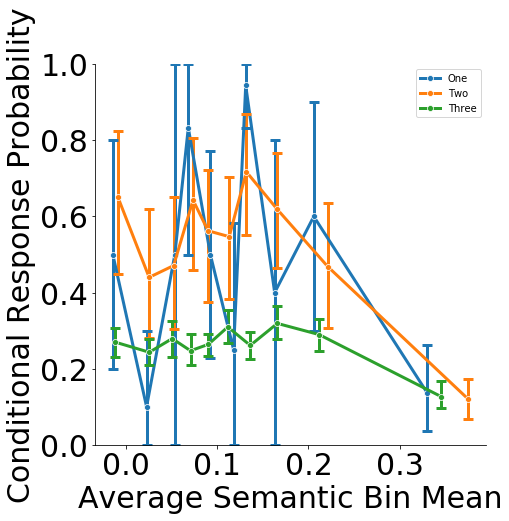

In [14]:
#using average bin value

ones_crp['avg_sem_bin_mean'] = ones_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
twos_crp['avg_sem_bin_mean'] = twos_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
thrs_crp['avg_sem_bin_mean'] = thrs_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
alls_crp['avg_sem_bin_mean'] = alls_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')


set_axes(ylim=[0, 1], xticks=np.arange(0, 0.41, 0.1), fontsize = 30)
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=ones_crp, linewidth = 3,
                 marker = 'o', err_style = 'bars', err_kws=error_bars, label = 'One')

g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=twos_crp, linewidth = 3,
                 marker = 'o', err_style = 'bars', err_kws=error_bars, label = 'Two')

g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=thrs_crp, linewidth = 3,
                 marker = 'o', err_style = 'bars', err_kws=error_bars, label = 'Three')

plt.ylabel('Conditional Response Probability')
plt.xlabel('Average Semantic Bin Mean')
plt.savefig(data_set+'_figs/sem_crp_split.pdf', bbox_inches='tight')

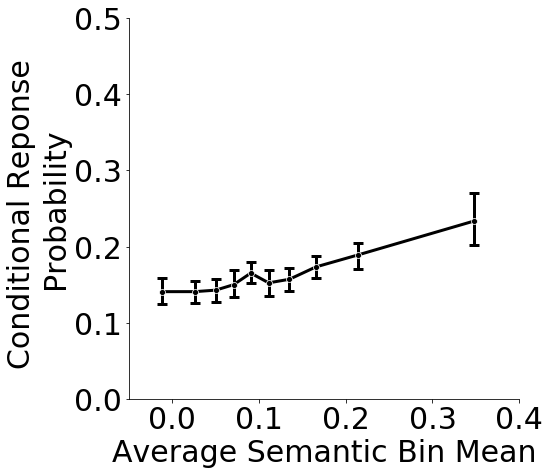

In [15]:
set_axes(ylim=[0, 0.5], xlim = [-0.05, 0.4], xticks=np.arange(0, 0.41, 0.1), fontsize = 30)

g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=alls_crp, linewidth = 3,
                 color = 'black', marker = 'o', err_style = 'bars', err_kws=error_bars)

plt.ylabel('Conditional Reponse \nProbability', fontsize = 30)
plt.xlabel('Average Semantic Bin Mean')

plt.savefig(data_set+'_figs/sem_crp.pdf', bbox_inches='tight')